## Pruning MLP on CIFAR-10

This Notebook gives a demo on how to prune the filters on an MLP on CIFAR-10.

**DEV:** _prune multiple layers._

### Settings

In [ ]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *


# specify experiment settings
expName = 'cifar-mlp-v1_w1-500'   #change conv1 dim
w1 = 500 # change conv1 dim
w2 = 100

batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
gamma = 0.1  # learning rate decay
lr_decay_step = 10 # decay lr every "x" epochs
momentum = 0.9
weight_decay = 5e-3

# -----------------------------------------------------------------------------


# experiment folder
expDir = os.path.join('./data', expName)

# setup and load CIFAR dataset - for MLP!!!!
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)

## Reduce Duplicate Filters

In [ ]:
# re-load the original network
net = MLP(fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

In [207]:
net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network data loss: 1.3798


In [208]:
# Settings
%matplotlib inline
from net_reduce import *

SIMIL_THRESH = 0.98
LAYER_CURR = 'fc2'
LAYER_NEXT = 'fc3'

### Network reduction

Reducing a network by eliminating near-duplicate filters consists of the following steps, after having formed groups of similar filters:

1. down-scale the filters of the current layer to have unit norm, and correspondingly up-scale the next layer filters.
2. collapse filter groups

In [209]:
# Check the network accuracy pre-reduction
net.eval()
net.cuda()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % orig_accu

net.cuda()
new_data_loss = get_dataset_loss(net, testloader)
orig_data_loss = np.asarray(orig_data_loss)
print 'Orig mean data loss: %f' % np.mean(orig_data_loss)

Network accuracy: 52.00%
Orig mean data loss: 1.379840


### Reduce similar filters


##### Check the norms after scaling

In [6]:
scale_net_params(net, LAYER_CURR, LAYER_NEXT)

In [7]:
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')

In [12]:
layer_curr_weights


 6.9534e-02  2.0148e-02 -6.6908e-02  ...  -9.6354e-03 -2.0751e-03  1.3790e-02
-1.5187e-01 -1.9607e-02 -3.4174e-03  ...  -5.9827e-03  1.0532e-02  1.1159e-02
-7.2148e-02  5.0515e-02  2.2661e-02  ...   8.1832e-03  2.0908e-02 -1.1897e-02
                ...                   ⋱                   ...                
-5.0502e-02 -1.7668e-02  4.6668e-02  ...   3.8741e-03 -9.8835e-03  3.8155e-02
 8.8680e-02  2.2084e-02 -6.8748e-02  ...   6.0556e-03  2.7000e-03 -4.8395e-04
-1.2530e-01 -1.3874e-02 -2.0258e-02  ...   6.2072e-03  1.4431e-02  2.0177e-03
[torch.FloatTensor of size 100x500]

In [8]:
torch.norm(layer_curr_weights[0],p=2)

1.0000000127540734

##### Check the reduction operation

In [210]:
# 1. unit-normalizes current layer filters
# 2. finds similar groups of filters and merges them

# code: net_reduce.py
#   return args are for diagnostics and n_comps needed for norm-baseline
n_comps, cc_list, similMat, adj_mat = \
reduce_similar_filters(net, LAYER_CURR, LAYER_NEXT, SIMIL_THRESH)

70


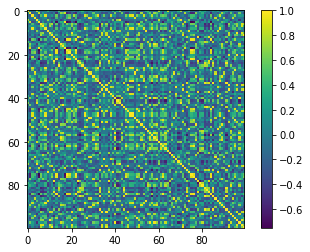

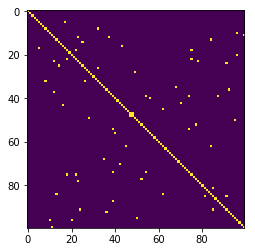

In [211]:
print n_comps
f = plt.figure()
plt.imshow(similMat)
plt.colorbar()
f = plt.figure()
plt.imshow(adj_mat)

In [213]:
# Sanity check: verify that the network's param sizes have changed
print net.fc2.weight.size()
print net.fc2.bias.size()
print net.fc3.weight.size()

torch.Size([70, 100])
torch.Size([70])
torch.Size([10, 70])


In [212]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

# res = {'orig_accu': orig_accu, 'reduced_accu': abl_accu, \
#        'num_filters': n_comps}
# with open(os.path.join(expDir,'reduce_dup_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
#     json.dump(res, res_file, indent=4, separators=(',', ': '), \
#                                           sort_keys=True)

Reduced network accuracy: 52.00 %


In [10]:
# save reduced network 
torch.save(net.state_dict(), os.path.join(expDir,'net-reduced-dup-%.2f.dat' % SIMIL_THRESH))

([], <a list of 0 Text yticklabel objects>)

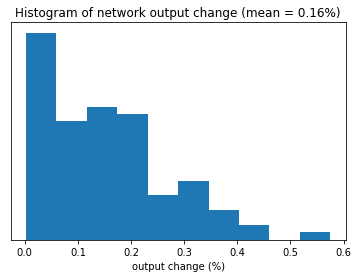

In [214]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
# f.savefig(os.path.join(expDir,'loss-delta-reduced-dup-%.2f.png' % SIMIL_THRESH))

### Baseline: low L1 norm

In [215]:
# baseline: keep same number of filters as the duplicate method
NUM_KEEP = n_comps 

# re-load the original network
net = MLP(fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)


Original network data loss: 1.3798


In [216]:
# code: net_reduce.py
reduce_low_norm_filters(net, LAYER_CURR, LAYER_NEXT, NUM_KEEP)

In [217]:
# Evaluate baseline network's accuracy
net.cuda()
net.eval()
baseline_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % baseline_accu

# res = {'orig_accu': orig_accu, 'reduced_accu': baseline_accu, \
#         'num_filters': n_comps}
# with open(os.path.join(expDir,'reduce_norm_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
#     json.dump(res, res_file, indent=4, separators=(',', ': '), \
#                                           sort_keys=True)

Reduced network accuracy: 52.00 %


([], <a list of 0 Text yticklabel objects>)

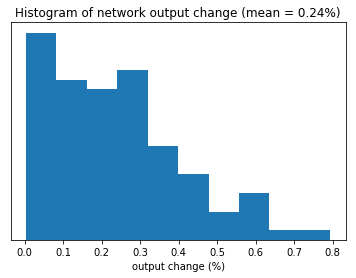

In [218]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
# f.savefig(os.path.join(expDir,'loss-delta-reduced-norm-%.2f.png' % SIMIL_THRESH))